### Libraries and Their Purpose

1. **numpy**: Used for numerical computations and handling arrays efficiently.
2. **pandas**: Utilized for data manipulation and analysis, especially for loading and processing the stock price dataset.
3. **sklearn.preprocessing.MinMaxScaler**: Scales features to a range of 0 to 1 to normalize data for better model training.
4. **sklearn.model_selection.train_test_split**: Splits the dataset into training and testing sets for model evaluation.
5. **tensorflow.keras.models.Sequential**: A simple way to build a neural network layer by layer.
6. **tensorflow.keras.layers.LSTM**: Implements Long Short-Term Memory units to handle sequential data and capture temporal patterns.
7. **tensorflow.keras.layers.Dense**: A fully connected layer for making predictions.
8. **tensorflow.keras.layers.Dropout**: Helps prevent overfitting by randomly dropping connections during training.
9. **tensorflow.keras.optimizers.Adam**: An efficient optimizer that combines the benefits of RMSProp and Momentum.
10. **sklearn.metrics**: Provides evaluation metrics such as MSE, MAE, and R² to measure model performance.
11. **matplotlib.pyplot**: Used for visualizing data, model performance, and residual analysis.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

### Loading the Dataset
The Google Stock Price dataset is loaded using the `pd.read_csv` function. This converts the CSV file into a Pandas DataFrame called `data` for further processing and analysis.

In [2]:
data = pd.read_csv('./Google_Stock_Price_Train.csv')
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


### Preparing the Dataset
1. The columns of the dataset are renamed for better readability.
2. The 'Date' column is converted to a datetime format to enable date-based operations.
3. The dataset is sorted by the 'Date' column to ensure chronological order, which is crucial for time-series analysis.

In [3]:
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

### Cleaning the Data
1. Non-numeric characters (e.g., commas, dollar signs) are removed from numeric columns to ensure clean data for processing.
2. The numeric columns are converted to `float` to make them compatible with the model and numerical operations.
3. Missing values, if any, are dropped to maintain data integrity and avoid errors during model training.


In [4]:
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
for column in numeric_columns:
    data[column] = data[column].replace({',': '', '\$': ''}, regex=True).astype(float)

data = data.dropna() 

### Feature Engineering: Temporal Features
1. Extracted `Year`, `Month`, and `Day` from the `Date` column to add additional features.
2. These temporal features provide more context about time-related trends and patterns in the stock price data.


In [5]:
# Feature engineering: Adding additional features (Year, Month, Day)
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

### Feature Engineering: Daily Returns
1. Computed `Daily_Return` to capture the percentage change in stock prices between consecutive days.
2. Removed the first row with `NaN` caused by the calculation to ensure clean data for modeling.


In [6]:
data['Daily_Return'] = data['Close'].pct_change()
data = data.dropna()

### Feature-Target Splitting and Scaling
1. **Feature Selection**: Selected relevant stock features (`Open`, `High`, `Low`, `Volume`, `Daily_Return`) as inputs (`X`) and stock `Close` price as the target (`y`).
2. **Data Normalization**: Applied `MinMaxScaler` to scale both features and target values to a range of 0 to 1. This step standardizes the data, making the model training process more efficient.


In [7]:
X = data[['Open', 'High', 'Low', 'Volume', 'Daily_Return']]
y = data[['Close']]

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

### Splitting Data for Training and Validation
1. **Data Splitting**: The dataset was divided into:
   - Training Set (80%): Used for model training.
   - Validation Set (20%): Used to evaluate the model's generalization on unseen data.
   - A random state of 42 ensures reproducibility.
2. **Preview**: Displayed a sample of the processed dataset to confirm correct transformations and feature engineering.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print("Processed data sample:")
print(data.head())

Processed data sample:
        Date    Open    High     Low   Close      Volume  Year  Month  Day  \
1 2012-01-04  331.27  333.87  329.08  666.45   5749400.0  2012      1    4   
2 2012-01-05  329.83  330.75  326.89  657.21   6590300.0  2012      1    5   
3 2012-01-06  328.34  328.77  323.68  648.24   5405900.0  2012      1    6   
4 2012-01-09  322.04  322.29  309.46  620.76  11688800.0  2012      1    9   
5 2012-01-10  313.70  315.72  307.30  621.43   8824000.0  2012      1   10   

   Daily_Return  
1      0.004310  
2     -0.013865  
3     -0.013649  
4     -0.042392  
5      0.001079  


### Defining and Compiling the LSTM Model
1. **Reshaping Input**: 
   - Input data reshaped into three dimensions `(samples, time steps, features)` to match LSTM requirements.
   - Time steps set to 1 for simplicity.
   
2. **Model Architecture**:
   - Stacked LSTM layers:
     - Five LSTM layers with 50 neurons each and `ReLU` activation.
     - Dropout layers (20%) added for regularization.
   - Final dense output layer with one neuron for predicting stock prices.

3. **Compilation**:
   - Optimizer: Adam (learning rate = 0.001).
   - Loss Function: MSE for error minimization.
   - Metric: MAE to track prediction accuracy.

4. **Model Summary**: Displayed architecture details to verify the configuration.


In [9]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
# model = Sequential([
#     LSTM(50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
#     Dense(1)  # Output layer with 1 neuron (regression task)
# ])

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Summary of the model
model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,051 (359.57 KB)

 Trainable params: 92,051 (359.57 KB)

 Non-trainable params: 0 (0.00 B)

### Training the LSTM Model
1. **Training Process**:
   - The model was trained using the `fit` function on the reshaped training data.
   - Validation data was used to monitor model performance during training.

2. **Key Parameters**:
   - **Epochs**: 50 iterations to optimize model weights.
   - **Batch Size**: 32 samples per batch for weight updates.
   - **Verbose Mode**: Set to 2 to display concise progress details.

3. **Validation**:
   - Included `X_test_reshaped` and `y_test` as validation data to check performance on unseen samples during training.


In [10]:
# Train the model
history = model.fit(
    X_train_reshaped,
    y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=50,
    batch_size=32,
    verbose=2
)

Epoch 1/50
32/32 - 2s - 55ms/step - loss: 0.1241 - mae: 0.2678 - val_loss: 0.0977 - val_mae: 0.2332
Epoch 2/50
32/32 - 0s - 1ms/step - loss: 0.0718 - mae: 0.1932 - val_loss: 0.0475 - val_mae: 0.1692
Epoch 3/50
32/32 - 0s - 1ms/step - loss: 0.0537 - mae: 0.1776 - val_loss: 0.0473 - val_mae: 0.1639
Epoch 4/50
32/32 - 0s - 2ms/step - loss: 0.0529 - mae: 0.1751 - val_loss: 0.0467 - val_mae: 0.1642
Epoch 5/50
32/32 - 0s - 2ms/step - loss: 0.0526 - mae: 0.1761 - val_loss: 0.0472 - val_mae: 0.1625
Epoch 6/50
32/32 - 0s - 2ms/step - loss: 0.0534 - mae: 0.1736 - val_loss: 0.0465 - val_mae: 0.1648
Epoch 7/50
32/32 - 0s - 2ms/step - loss: 0.0531 - mae: 0.1764 - val_loss: 0.0465 - val_mae: 0.1610
Epoch 8/50
32/32 - 0s - 2ms/step - loss: 0.0517 - mae: 0.1731 - val_loss: 0.0463 - val_mae: 0.1601
Epoch 9/50
32/32 - 0s - 2ms/step - loss: 0.0527 - mae: 0.1719 - val_loss: 0.0455 - val_mae: 0.1610
Epoch 10/50
32/32 - 0s - 2ms/step - loss: 0.0508 - mae: 0.1703 - val_loss: 0.0449 - val_mae: 0.1585
Epoch 11

### Evaluating the Model
1. **Purpose**:
   - To assess the model's performance on unseen data using the test set.

2. **Metrics**:
   - **Test Loss**: Represents the Mean Squared Error (MSE), indicating how far the predictions are from actual values.
   - **Test MAE**: Indicates the average absolute difference between predicted and actual values.

3. **Evaluation Function**:
   - Used `.evaluate()` to calculate the metrics on `X_test_reshaped` and `y_test`.
   - Metrics help understand the model's accuracy and error magnitude on new data.

In [11]:
# Evaluate the model
loss, mae = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Test Loss: 0.0231, Test MAE: 0.0794


### Making Predictions and Rescaling
1. **Predictions**:
   - Used the trained model to predict stock prices on the reshaped test data (`X_test_reshaped`).
   - Predictions are initially scaled values as the model was trained on normalized data.

2. **Rescaling**:
   - Converted predictions (`y_pred`) and actual test values (`y_test`) back to their original scale using the `inverse_transform` method of the scaler.
   - Rescaled values make it easier to interpret and compare predictions with actual stock prices.

In [12]:
# Make predictions
y_pred = model.predict(X_test_reshaped)

# Convert predictions back to original scale
y_pred_rescaled = target_scaler.inverse_transform(y_pred)
y_test_rescaled = target_scaler.inverse_transform(y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


### Evaluating Model Performance
1. **Metrics Used**:
   - **MSE**: Calculates the average squared error, useful for identifying large deviations.
   - **MAE**: Measures the average error in the same units as the target variable.
   - **RMSE**: Provides an interpretable error magnitude.
   - **R²**: Indicates how well the model explains variability in the target variable.

2. **Results**:
   - The metrics provide a comprehensive understanding of the model’s performance by quantifying errors and overall predictive capability.


In [13]:
# Evaluate the model
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 12144.42
Mean Absolute Error (MAE): 57.59
Root Mean Squared Error (RMSE): 110.20
R-squared (R²): 0.51


### Plotting Actual vs Predicted Stock Prices
- **Purpose**:
  - Compare the model's predicted stock prices against actual values to evaluate performance visually.
- **Description**:
  - **X-axis**: Represents the test samples.
  - **Y-axis**: Represents the stock price values.
  - The line graph showcases how well the model captures trends in the stock prices.
  - The alignment between "Actual" and "Predicted" lines indicates the model's effectiveness.

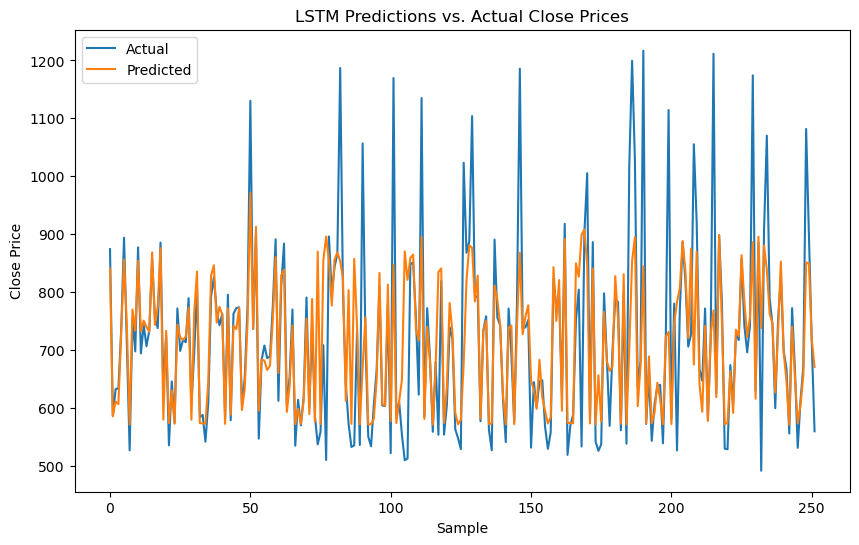

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Actual")
plt.plot(y_pred_rescaled, label="Predicted")
plt.title("LSTM Predictions vs. Actual Close Prices")
plt.xlabel("Sample")
plt.ylabel("Close Price")
plt.legend()
plt.show()

### Residuals Distribution
- **Purpose**:
  - Analyze the differences between actual and predicted values to understand prediction errors.
- **Description**:
  - **X-axis**: Residual values (Actual - Predicted).
  - **Y-axis**: Frequency of residuals.
  - The histogram shows how errors are distributed:
    - A concentration around zero indicates accurate predictions with minimal bias.
    - Wider distributions or outliers highlight areas where the model underperforms.


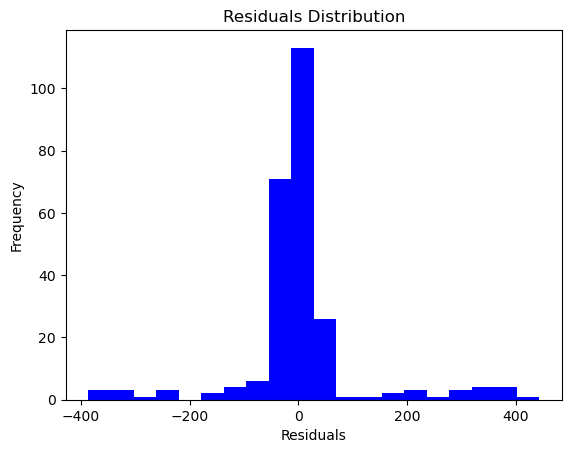

In [15]:
residuals = y_test_rescaled - y_pred_rescaled
plt.hist(residuals, bins=20, color='blue')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

### Training vs Validation Loss Plot

- **Purpose**: This step visualizes the changes in the model's loss for both training and validation datasets across all epochs.
- **Key Insights**:
  - The training loss represents how well the model performs on the training dataset after each epoch.
  - The validation loss reflects the model's performance on unseen data, indicating its ability to generalize.
  - The legend distinguishes between the training and validation loss curves.
- **Expected Outcome**: A consistent decrease in both training and validation loss indicates effective training. Close alignment of the two curves suggests that the model generalizes well and avoids overfitting.


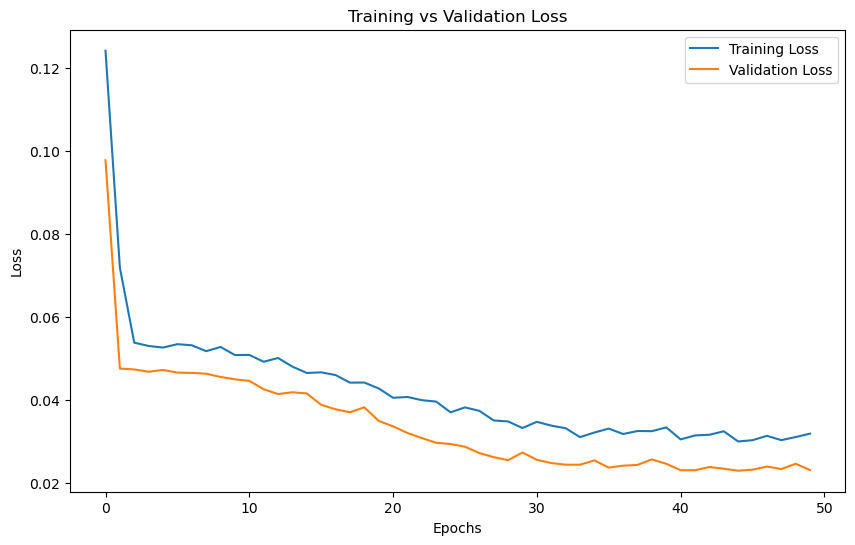

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Low-Error Case Analysis

- **Purpose**: This step identifies and analyzes the cases where the model's predictions closely match the actual stock prices.
- **Description**:
  - **Flattening Data**: Converts `y_test_rescaled` and `y_pred_rescaled` to 1D arrays for easier comparison.
  - **Absolute Errors**: The absolute differences between predicted and actual values are calculated to measure prediction accuracy.
  - **Low-Error Indices**: The smallest error values are identified and sorted in descending order for better interpretation.
- **Expected Outcome**: Low-error cases highlight the scenarios where the model performs exceptionally well, typically in stable market conditions or when trends are easier to predict.


In [17]:
y_test_rescaled_flat = y_test_rescaled.flatten()
y_pred_rescaled_flat = y_pred_rescaled.flatten()

# Calculate absolute errors
errors = np.abs(y_test_rescaled_flat - y_pred_rescaled_flat)


low_error_indices = np.argsort(errors)[0:5][::-1]  # Top 5 smallest errors in descending order
# Print low-error cases
print("low-error cases:")
for idx in low_error_indices:
    print(f"Actual: {y_test_rescaled_flat[idx]}, Predicted: {y_pred_rescaled_flat[idx]}, Error: {errors[idx]}")

low-error cases:
Actual: 736.1, Predicted: 736.5787353515625, Error: 0.47873535156247726
Actual: 602.98, Predicted: 603.3623657226562, Error: 0.3823657226562318
Actual: 898.21, Predicted: 898.517822265625, Error: 0.3078222656249636
Actual: 611.11, Predicted: 610.8657836914062, Error: 0.24421630859376364
Actual: 716.98, Predicted: 717.1362915039062, Error: 0.1562915039062318


### High-Error Case Analysis

- **Purpose**: To identify and examine cases where the model's predictions deviate significantly from actual values.
- **Description**:
  - **Absolute Errors**: Errors between the predicted and actual values are calculated.
  - **High-Error Indices**: The largest error values are identified and sorted in descending order to highlight the most challenging cases for the model.
  - **Error Examination**: Specific instances with high errors are analyzed to understand the model's limitations.
- **Expected Outcome**: High-error cases often occur during market volatility or unusual trends, revealing areas where the model could be improved, such as handling sharp spikes or dips more effectively.


In [18]:
high_error_indices = np.argsort(errors)[-5:][::-1]  # Top 5 largest errors in descending order
print(high_error_indices)
# Print high-error cases
print("high-error cases:")
for idx in high_error_indices:
    print(f"Actual: {y_test_rescaled_flat[idx]}, Predicted: {y_pred_rescaled_flat[idx]}, Error: {errors[idx]}")


[215  90  77 199 208]
high-error cases:
Actual: 1211.58, Predicted: 768.0867309570312, Error: 443.4932690429687
Actual: 1056.69, Predicted: 669.64501953125, Error: 387.04498046875005
Actual: 509.77000000000004, Predicted: 895.8956909179688, Error: 386.1256909179687
Actual: 1114.4, Predicted: 730.9981079101562, Error: 383.40189208984384
Actual: 1055.28, Predicted: 674.6082153320312, Error: 380.6717846679687


### Directional Accuracy Calculation

- **Purpose**: To assess the model's ability to predict the direction of stock price movements accurately (upward or downward trends).
- **Description**:
  - **Trend Calculation**:
    - `np.diff()` computes the difference between consecutive stock prices to determine the trend (positive for upward, negative for downward).
  - **Comparison**:
    - The actual trends are compared with the predicted trends using `np.mean()` to calculate the percentage of correct predictions.
- **Expected Outcome**:
  - A high directional accuracy percentage indicates that the model is effective in capturing the general movement of stock prices, which is particularly useful for decision-making in trading scenarios.


In [19]:
# Directional Accuracy
actual_trend = np.sign(np.diff(y_test_rescaled_flat))
predicted_trend = np.sign(np.diff(y_pred_rescaled_flat))

directional_accuracy = np.mean(actual_trend == predicted_trend)
print(f"Directional Accuracy: {directional_accuracy * 100:.2f}%")

Directional Accuracy: 82.47%
